In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from einops import rearrange

import sys
sys.path.append('../')

from model import PatchFMLit
from dataset import artificial_dataset, UTSDataset

In [2]:
#model = PatchFMLit.load_from_checkpoint("../ckpts/patchfm_216_80wu4_256.ckpt")
model = PatchFMLit.load_from_checkpoint("../ckpts/10_epochs_3wu_12totalepochs_bs256_arti_real.ckpt")

print(sum(p.numel() for p in model.parameters()))
model.eval()

/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/svilhes/anaconda3/envs/anots/li

80208560


PatchFMLit(
  (model): PatchFM(
    (revin): RevIN()
    (proj_embedding): ResidualBlock(
      (dropout): Dropout(p=0.15, inplace=False)
      (hidden_layer): Linear(in_features=32, out_features=64, bias=True)
      (output_layer): Linear(in_features=64, out_features=1024, bias=True)
      (residual_layer): Linear(in_features=32, out_features=1024, bias=True)
      (act): ReLU()
    )
    (dp): Dropout(p=0.15, inplace=False)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiHeadAttention(
            (WQ): Linear(in_features=1024, out_features=1024, bias=True)
            (WK): Linear(in_features=1024, out_features=1024, bias=True)
            (WV): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (rope): RotaryEmbedding()
     

# artificial dataset

In [4]:
dataset = torch.load("../data/full.pt") # approx 40sec to load

/tmp/ipykernel_2387802/832420037.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("../data/full.pt") # approx 40sec to load


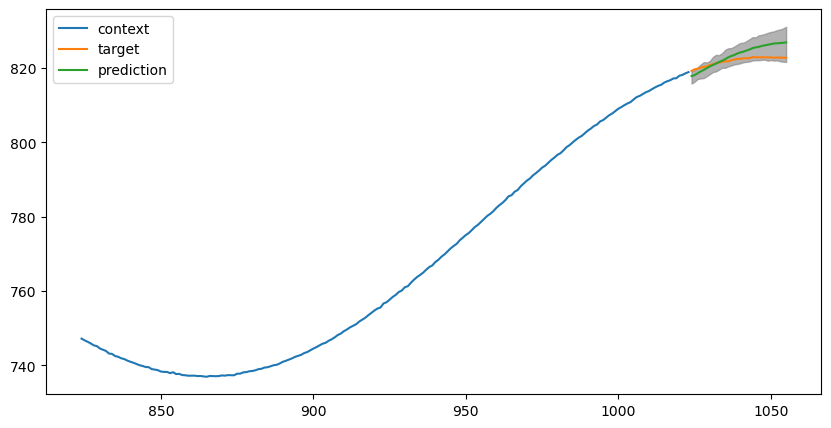

In [41]:
idx = random.randint(0, len(dataset))
input, target = dataset[idx]

context = input.clone()

input = input.unsqueeze(0).to('cuda')
with torch.inference_mode():
  prediction = model.model(input)[0, -1, :, :].detach().cpu().numpy()

median = prediction[:, list(model.model.quantiles).index(0.5)]
lower = prediction[:, list(model.model.quantiles).index(0.1)]
upper = prediction[:, list(model.model.quantiles).index(0.9)]

plt.figure(figsize=(10, 5))

plt.plot(range(len(context))[-200:], context[-200:], label="context")
plt.plot(range(len(context), len(context)+len(target)), target, label="target")

plt.plot(range(len(context), len(context)+len(target)), median, label="prediction")
plt.fill_between(range(len(context), len(context)+len(target)), lower, upper, color="grey", alpha=0.6)

plt.legend()

# real dataset

In [6]:
dataset = UTSDataset(input_len=model.model.seq_len, output_len=model.model.patch_len, flag="val")

Resolving data files:   0%|          | 0/320 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/80 [00:00<?, ?it/s]

Indexing dataset...


100%|██████████| 68679/68679 [00:28<00:00, 2437.63it/s]


In [7]:
len(dataset)

6942887

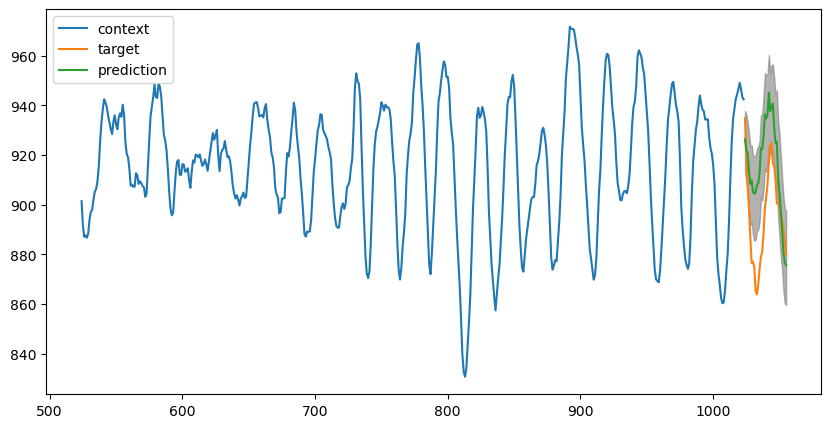

In [74]:
idx = random.randint(0, len(dataset))
input, target = dataset[idx]

context = input.clone()

input = input.unsqueeze(0).to('cuda')
with torch.no_grad():
  prediction = model.model(input)[0, -1, :, :].detach().cpu().numpy()

median = prediction[:, list(model.model.quantiles).index(0.5)]
lower = prediction[:, list(model.model.quantiles).index(0.1)]
upper = prediction[:, list(model.model.quantiles).index(0.9)]

plt.figure(figsize=(10, 5))

plt.plot(range(len(context))[-500:], context[-500:], label="context")
plt.plot(range(len(context), len(context)+len(target)), target, label="target")

plt.plot(range(len(context), len(context)+len(target)), median, label="prediction")
plt.fill_between(range(len(context), len(context)+len(target)), lower, upper, color="grey", alpha=0.6)

plt.legend()